# Make $A_s$ maps

In [13]:
#set up values and functions
#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


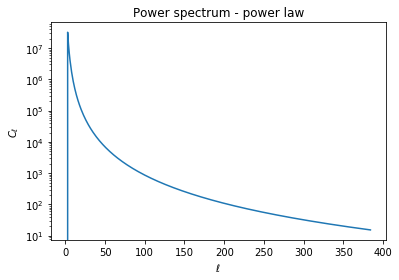

In [14]:
#define C_ell with a power law dependence on ell
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0

#input power spectrum
semilogy(ells,pcls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Power spectrum - power law");

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


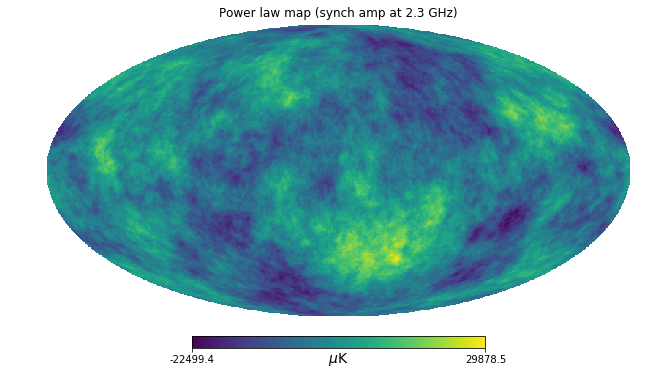

In [15]:
#produce power law map
sbb = hp.synfast(pcls, nside, new=True)
hp.mollview(sbb, unit=r'$\mu \rm K$', title='Power law map (synch amp at 2.3 GHz)')

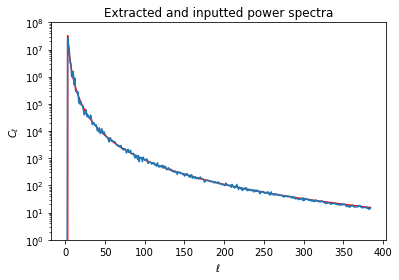

In [16]:
#now extract the power spectrum (the C_ells) from the map
check_cls = hp.anafast(sbb)

#compare the measured C_ell to the input C_ell curve

semilogy(ells, pcls, 'r')
semilogy(ells, check_cls)
xlabel("$\ell$")
ylabel("$C_\ell$")
title("Extracted and inputted power spectra")
ylim(1, 1e8);

# Produce maps including the SED

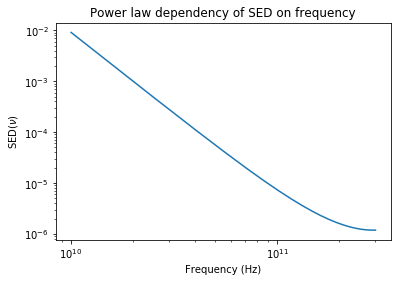

In [17]:
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9


#define the SED scaling
sed_scaling_const = scale_synch(freqs, beta_BB)


#plot the SED against frequency (on log log plot)
loglog(freqs, sed_scaling_const)
xlabel("Frequency (Hz)")
ylabel(r"$\mathrm{SED}(\nu)$") #the r is needed for the LaTeX
title("Power law dependency of SED on frequency");

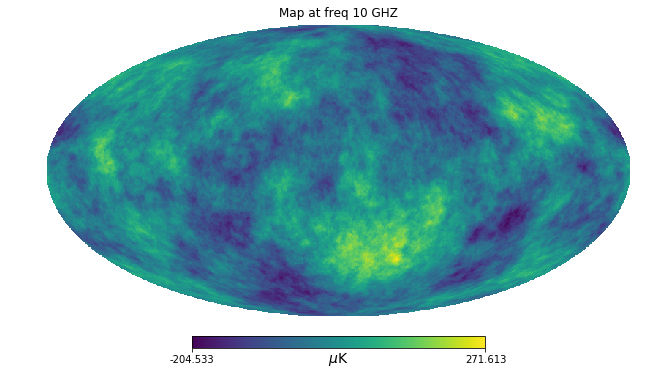

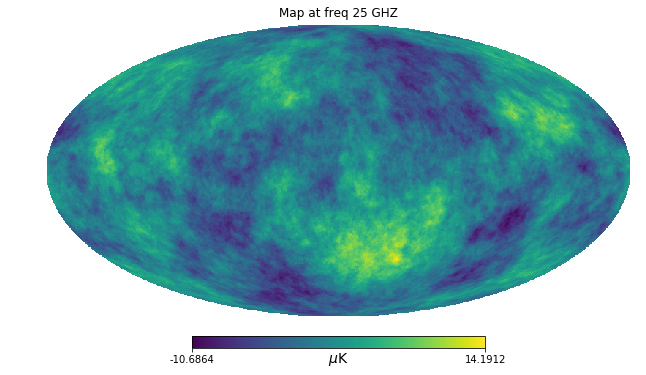

In [18]:
#the maps including SED at different frequencies
newmaps_const = sbb * sed_scaling_const[..., np.newaxis]

for k in range(2): #can extend this range up to 20 to get all the maps
    hp.mollview(newmaps_const[k], title = "Map at freq %d GHZ" %(1e-9*freqs[k]), unit = r"$\mu \rm K$")
    


# Allow $\beta$ to vary (uniform $C_\ell^\beta$).

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
mean of beta map = -3.1999999999999997
std of beta map = 0.13257166262039516


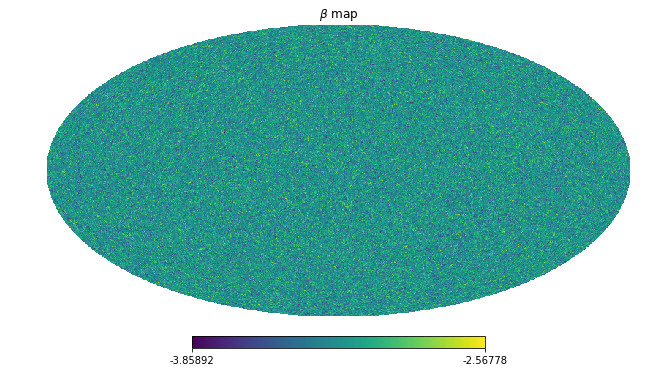

In [64]:
#define a standard deviation that gives rise to a map about the size
#expected

beta_sigma = 1.5e-6

#define a 'beta map' using uniform C_ell
beta_cls = beta_sigma * ones_like(ells)  #makes a vector [1.5e-6, ... , 1.5e-6] with the same shape as the ells
beta_map = hp.synfast(beta_cls, nside, new=True)

#update the map so that the mean is correct
beta_map -= (np.mean(beta_map) + 3.2)

#check map is as expected: mean ~3.2, std ~0.1
print("mean of beta map = " + str(np.mean(beta_map)))
print("std of beta map = " + str(np.std(beta_map)))

#view beta map
hp.mollview(beta_map, title=r"$\beta \ \rm map$")

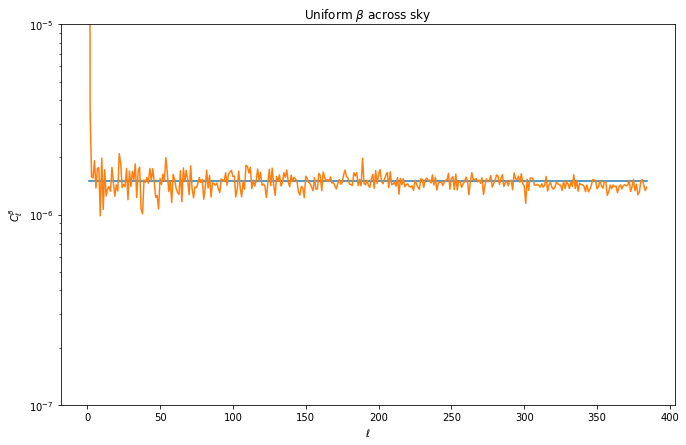

In [65]:
#check beta_cls from this map compared to input (uniform spectrum)
check_bcls = hp.anafast(beta_map)

figure(figsize=(11,7))
semilogy(ells, beta_cls)
semilogy(ells, check_bcls)
ylim(1e-7, 1e-5)
xlabel("$\ell$")
ylabel(r"$ C_\ell^{\beta}$") 
title(r"Uniform $\beta$ across sky");

# Use this $\beta$ to make a series of maps

(196608, 20)


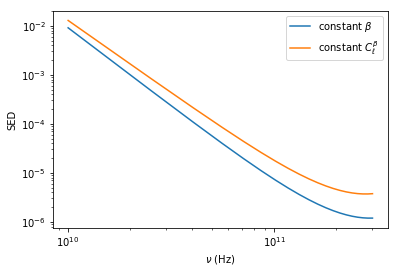

In [69]:
#we now want to take (nu/nu_0)^beta_map

#define the new, varying SED
sed_scaling_uniform = scale_synch(freqs, beta_map) 
print(sed_scaling_uniform.shape)
#!!! why is this the wrong shape?


loglog(freqs, sed_scaling_const, label=r"constant $\beta$")
loglog(freqs, sed_scaling_uniform[1], label=r"constant $C_\ell^\beta$")
xlabel(r'$\nu$ (Hz)')
ylabel('SED')
legend();
#I have to pick out the right column so I'm not sure what I've done is right

In [1]:
#make the maps from nu/nu_0^beta_map

#the following line crashes, I assume because I'm running over the
#196608 dimension, not the 20 dimension. I'm unclear why this array has
#the 20 at index 1 not index 0

#newmaps_uniform = beta_map * sed_scaling_uniform[..., np.newaxis]